In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

import math
from math import sqrt

import matplotlib
import seaborn as sns
import plotly.express as px

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error, mean_absolute_percentage_error

In [2]:
# .csv dosyasının pandas read_csv metodu ile okunarak "data" adlı değişkene atanması: 

data = pd.read_csv("data.csv")

# veri setinin ilk beş elemanı: 
data.head()

Tarih   Saat T�ketim Miktar� (MWh)
0  01.01.2017  00:00             27.223,06
1  01.01.2017  01:00             25.825,90
2  01.01.2017  02:00             24.252,68
3  01.01.2017  03:00             22.915,47
4  01.01.2017  04:00             22.356,99

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51048 entries, 0 to 51047
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tarih                  51048 non-null  object
 1   Saat                   51048 non-null  object
 2   T�ketim Miktar� (MWh)  51048 non-null  object
dtypes: object(3)
memory usage: 1.2+ MB


In [4]:
# veri setinin bir kopyasını oluturup "df" adlı bir değişkene atanması:

df = data.copy()

# kolon isimlerinin anlaşılır hale getirilmesi, tarih belirten kolonun datetime formatına çevrilmesi:

df['Tarih'] =pd.to_datetime(df['Tarih'] +' '+ df['Saat'], format='%d.%m.%Y %H:%M')

df = df.drop(columns = ["Saat"])
df = df.rename(columns={'T�ketim Miktar� (MWh)':'Tuketim'})

# tüketim değerlerini ifade eden "consumption" kolonundaki verilerin string tipinden float tipine dönüştürülmesi:

df['Tuketim'] = df['Tuketim'].str.replace('.', "" ,regex=True)
df["Tuketim"] = df["Tuketim"].str.replace(',', '.')
df["Tuketim"] = df["Tuketim"].astype(float)

df = df[["Tarih","Tuketim"]]

df.head()

Tarih   Tuketim
0 2017-01-01 00:00:00  27223.06
1 2017-01-01 01:00:00  25825.90
2 2017-01-01 02:00:00  24252.68
3 2017-01-01 03:00:00  22915.47
4 2017-01-01 04:00:00  22356.99

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51048 entries, 0 to 51047
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tarih    51048 non-null  datetime64[ns]
 1   Tuketim  51048 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 797.8 KB


In [6]:
# saatlik frekanstaki verilerin günlük frekansa çekilmesi, "Tarih" kolonunu da indeks olarak verilmesi ve data_daily adlı değişkene atanması:

data_daily = df.set_index("Tarih").asfreq('D')
data_daily.head()

Tuketim
Tarih               
2017-01-01  27223.06
2017-01-02  27477.70
2017-01-03  30859.74
2017-01-04  31313.51
2017-01-05  31433.88

In [7]:
# betimsel istatistikler : 

data_daily.describe()

Tuketim
count   2127.000000
mean   32658.831970
std     3320.528385
min    20627.680000
25%    30398.630000
50%    32361.130000
75%    34677.295000
max    44984.420000

In [8]:
# kayıp veri kontrolü :

data_daily.isnull().sum()

Tuketim    0
dtype: int64

In [9]:
# yinelenen (duplike) veri kontrolü:

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


Tuketim
Tarih               
2019-01-06  30573.30
2019-01-26  31701.58
2022-01-10  32456.36

In [10]:
# duplike verilerin drop edilmesi: 

data_daily.drop_duplicates(inplace=True)

In [11]:
# duplike verilerin drop edilmesinden sonra tekrar kontrol edilmesi: 

duplicate = data_daily[data_daily.duplicated()]
 
print("Duplicate Rows :")
duplicate

Duplicate Rows :


Empty DataFrame
Columns: [Tuketim]
Index: []

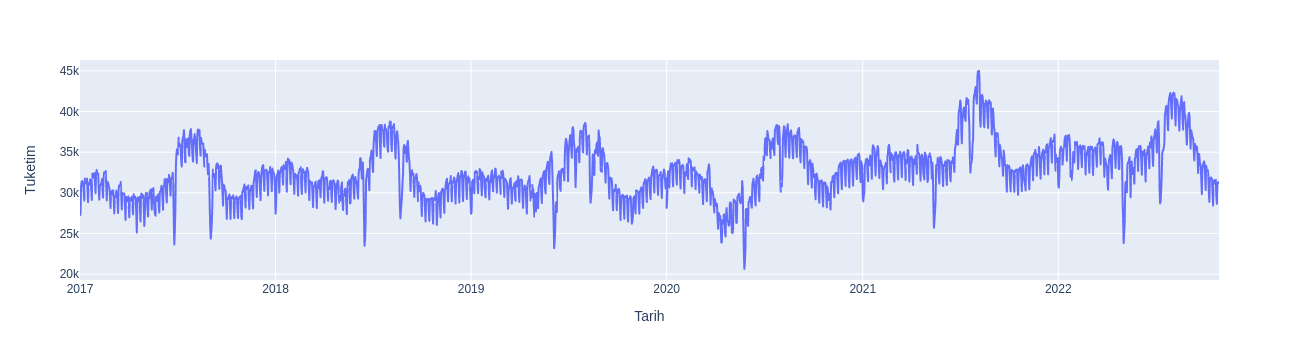

In [12]:
# verilerin çizgi grafiği üzerinde gösterilmesi:

fig = px.line(data_daily.reset_index(), x="Tarih", y="Tuketim")
fig.show()

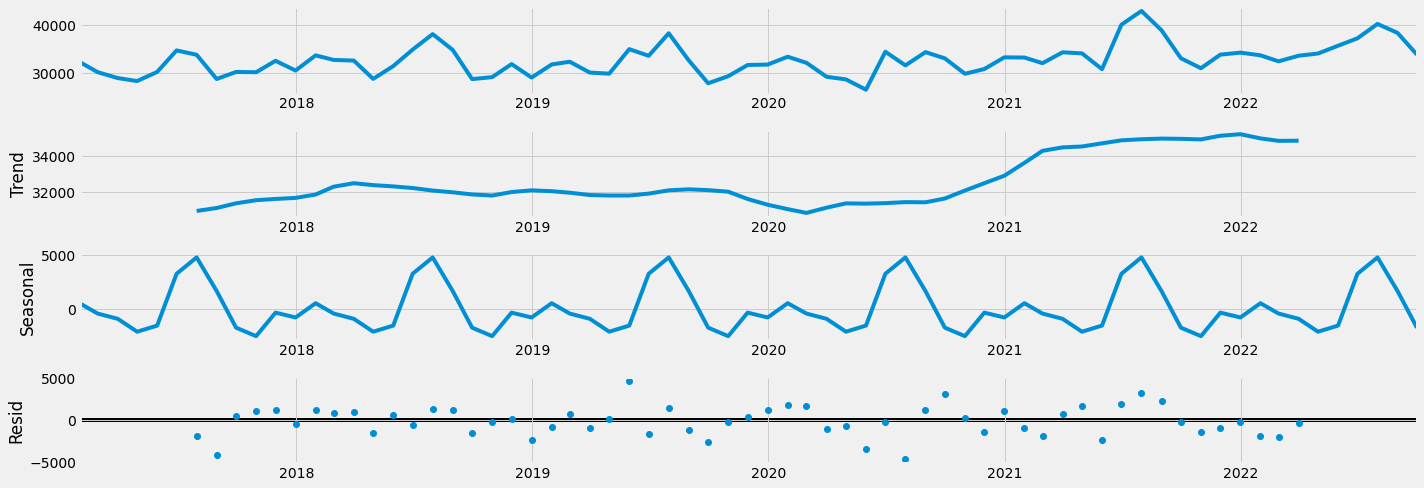

In [13]:
# zaman serisi bileşenleri: 

data_monthly = df.set_index("Tarih").asfreq('M')

plt.rcParams['figure.figsize'] = [20,7]
decomposition = sm.tsa.seasonal_decompose(data_monthly)
fig = decomposition.plot()
plt.show()

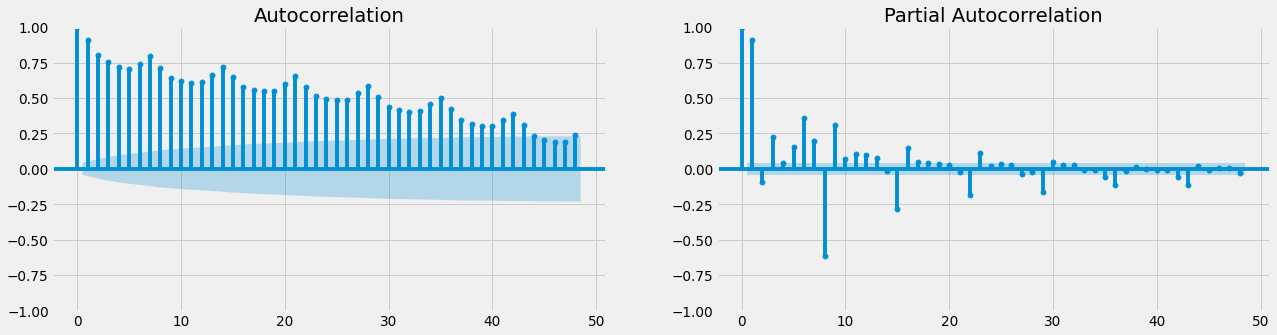

In [14]:
# otokorelasyon ve kısmı otokorelasyon grafikleri (ACF-PACF): 

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

1- Augmented Dickey-Fuller Test 
* Sıfır Hipotez H0 : Seri Durağan Değildir
* Alternati Hipotez H1 :Seri Durağandır(Birim Kök Yoktur)

2- Kwiatkowski-Phillips-Schmidt-Shin Test
* Sıfır Hipotez H0 : Seri durağandır
* Alternati Hipotez H1: Seri durağan değildir(Seri Birim Kök İçerir)

In [17]:
# ADF Testi:

def adf(data):
    adf_test = sm.tsa.adfuller(data, autolag='AIC')
    print(f'ADF Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    print("Seri Durağan Değildir") if adf_test[1] > 0.05 else print("Seri Durağandır(Birim Kök Yoktur)")

# KPSS Testi:

def kpss(data):
    kpss_test = sm.tsa.kpss(data)
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print("Seri Durağandır") if kpss_test[1] > 0.05 else print("Seri durağan değildir(Seri Birim Kök İçerir)")

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.7221431919940757
p-value: 0.0038122541107857327
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 2.036812
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [19]:
# ADF testi bir birim kök bulamazsa, ancak KPSS testi bulursa, seri fark durağandır ve yine de fark alınması gerekir.

In [20]:
data_daily_diff = data_daily.copy()
data_daily_diff['Tuketim'] = data_daily['Tuketim'] - data_daily['Tuketim'].shift(1)
data_daily_diff = data_daily_diff.dropna()

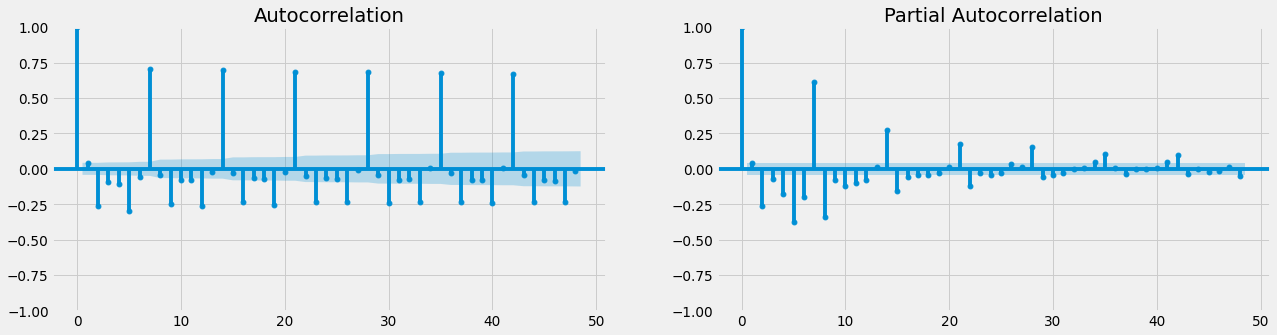

In [21]:
#  1. farkı alınmış serinin ACF ve PACF grafikleri:

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [22]:
#  1. farkı alınmış serinin ADF-KPSS testleri: 

adf(data_daily)
print()
kpss(data_daily)

ADF Statistic: -3.7221431919940757
p-value: 0.0038122541107857327
Seri Durağandır(Birim Kök Yoktur)

KPSS Statistic: 2.036812
p-value: 0.010000
Seri durağan değildir(Seri Birim Kök İçerir)


/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [23]:
# farkı alınmış seri üzerinde mevsimsel fark uygulanması: 

data_daily_diff2 = data_daily_diff.diff(7).dropna()

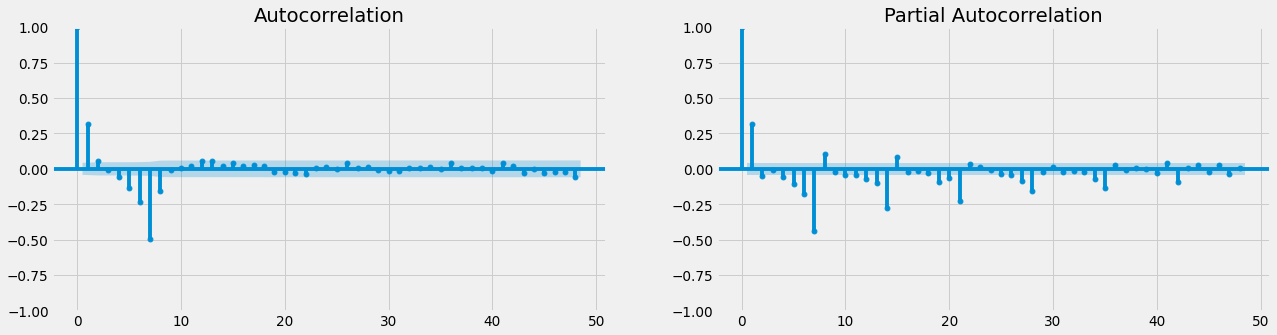

In [24]:
#  ACF ve PACF plot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5), dpi= 70)

plot_acf(data_daily_diff2.Tuketim.tolist(), ax=ax1, lags=48)
plot_pacf(data_daily_diff2.Tuketim.tolist(), ax=ax2, lags=48, method="ywm")

plt.show()

In [25]:
# veri setinin eğitim ve test seti olarak ayrıştırılması : 

train_data = data_daily['2021-01-01':'2022-09-30']
test_data = data_daily['2022-10-01':'2022-10-28']
pred_df = test_data.copy()

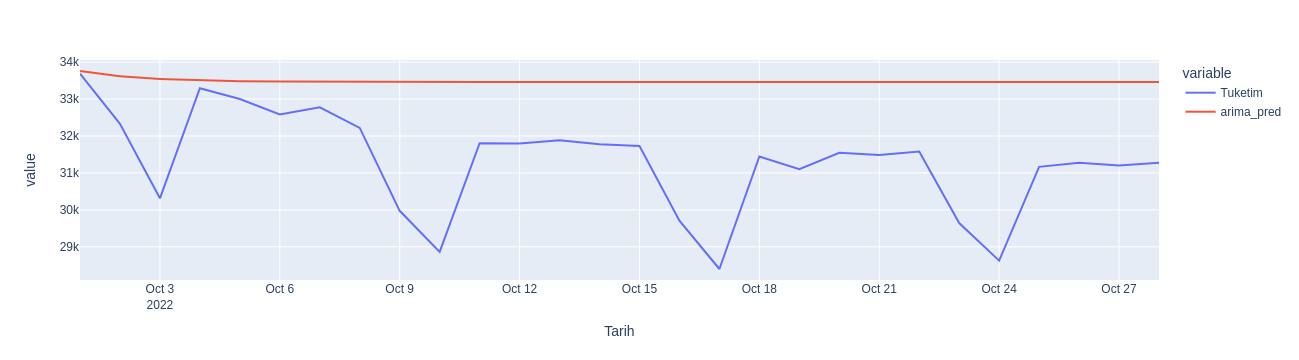

In [26]:
# ARIMA (2,1,2)

arima_model = sm.tsa.arima.ARIMA(np.asarray(train_data),order=(2,1,2))
arima_model_fit = arima_model.fit()
arima_pred = arima_model_fit.forecast(len(test_data),disp=False)

pred_df["arima_pred"] = arima_pred.round(2)

fig = px.line(pred_df[['Tuketim', 'arima_pred']])
fig.show()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22151D+00    |proj g|=  1.43842D-01

At iterate    5    f=  8.18955D+00    |proj g|=  4.50340D-03

At iterate   10    f=  8.18937D+00    |proj g|=  1.35152D-03

At iterate   15    f=  8.18930D+00    |proj g|=  4.79936D-03

At iterate   20    f=  8.18848D+00    |proj g|=  8.88658D-03

At iterate   25    f=  8.18501D+00    |proj g|=  7.90254D-03

At iterate   30    f=  8.18337D+00    |proj g|=  1.46150D-02

At iterate   35    f=  8.17925D+00    |proj g|=  4.45327D-03

At iterate   40    f=  8.17872D+00    |proj g|=  5.09958D-04

At iterate   45    f=  8.17864D+00    |proj g|=  2.90469D-04

At iterate   50    f=  8.17854D+00    |proj g|=  3.81123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/merve/notebooks/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



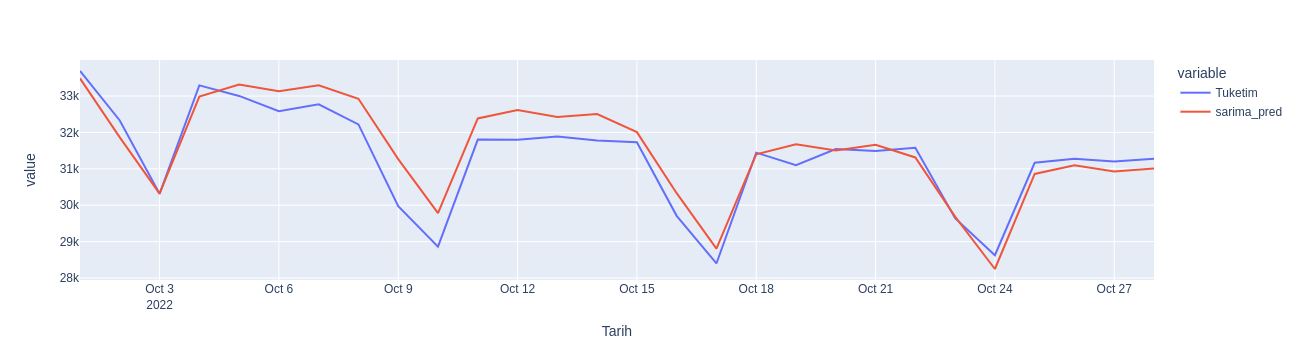

In [27]:
# SARIMA (2,1,2) (2,1,2,7)

sarima_model = SARIMAX(np.asarray(train_data), order=(2, 1, 2), seasonal_order=(2,1,2,7))
sarima_model_fit = sarima_model.fit()

sarima_pred = sarima_model_fit.forecast(len(test_data))

pred_df["sarima_pred"] = sarima_pred
fig = px.line(pred_df[['Tuketim', 'sarima_pred']])
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.13468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5962.81   0.000739254       285.006           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5971.97    0.00242035       277.619           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5975.22    0.00377454       404.647       1.452      0.3953      378   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5976.72     0.0016483       168.258           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     447       5976.96   3.11333e-05       88.3525   2.567e-07       0.001      606  LS failed, Hessian reset 
     499       5977.06   6.28161e-05    

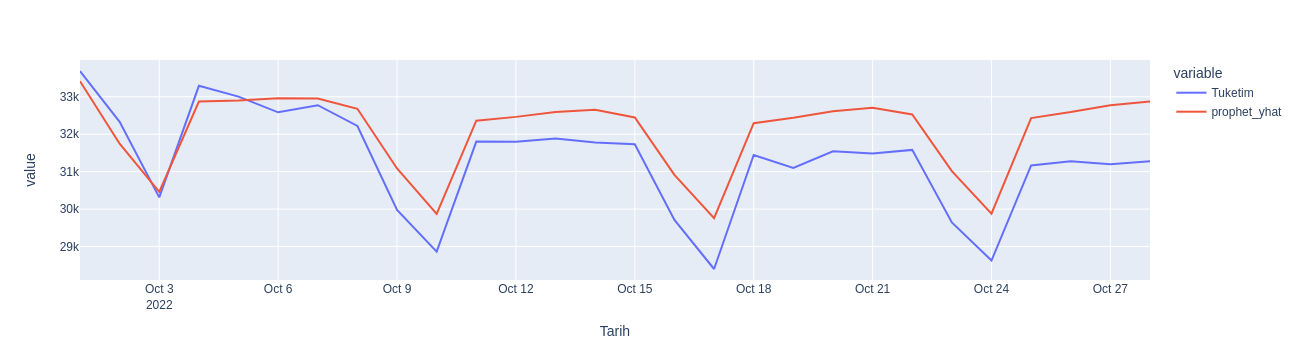

In [28]:
# PROPHET
prophet_df = data_daily.reset_index()
prophet_df.columns = ["ds","y"]

train_data_prophet = prophet_df[prophet_df['ds'] < '2022-10-01']
test_data_prophet = prophet_df[prophet_df['ds'] >= '2022-10-01']

prophet_model = Prophet()

# Fitting the model
prophet_model.fit(train_data_prophet)

# Prdicting on the test data
model_predict = prophet_model.predict(test_data_prophet)

pred_df["prophet_yhat"] = model_predict["yhat"].values.round(2)
pred_df["prophet_yhat_lower"] = model_predict["yhat_lower"].values.round(2)
pred_df["prophet_yhat_upper"] = model_predict["yhat_upper"].values.round(2)

fig = px.line(pred_df[['Tuketim', 'prophet_yhat']])
fig.show()

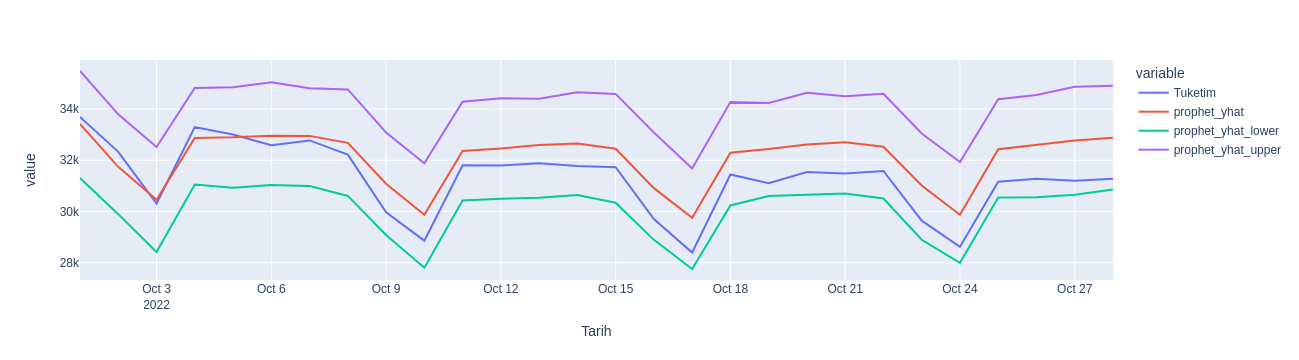

In [29]:
fig = px.line(pred_df[['Tuketim', 'prophet_yhat', 'prophet_yhat_lower','prophet_yhat_upper']])
fig.show()

In [30]:
prophet_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_r = r2_score(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values)
prophet_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["prophet_yhat"].values))

arima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_r = r2_score(pred_df["Tuketim"].values, pred_df["arima_pred"].values)
arima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["arima_pred"].values))

sarima_mape = mean_absolute_percentage_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_r = r2_score(pred_df["Tuketim"].values, pred_df["sarima_pred"].values)
sarima_rmse = math.sqrt(mean_squared_error(pred_df["Tuketim"].values, pred_df["sarima_pred"].values))

results = {'Prophet': [prophet_mape,prophet_rmse,prophet_r], 
        'ARIMA': [arima_mape,arima_rmse,arima_r],
        'SARIMA': [sarima_mape,sarima_rmse,sarima_r]}
results = pd.DataFrame(results,index=['MAPE','RMSE','R2'])
results

Prophet        ARIMA      SARIMA
MAPE    0.028417     0.071611    0.013551
RMSE  980.441226  2540.527917  512.284241
R2      0.454443    -2.663070    0.851057